# Pose Error Project

In [1]:
import os
import sys
import time
import pickle
import json
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

#from tqdm import tqdm
# since we are using it in jupyter notebook
from tqdm.notebook import tqdm

import random
random.seed(2024)

# import torch
# torch.manual_seed(2024)
# from torch.utils.data import DataLoader

# import torch.utils.tensorboard as tb 
# from torch.utils.tensorboard import SummaryWriter
# %reload_ext tensorboard
# writer = SummaryWriter()

from deepSEEConfig import DeepSEEConfig

# import logging
# logging.basicConfig(filename='running.log', encoding='utf-8', level=logging.DEBUG)
# logger = logging.getLogger(__name__)
# logger.info("Loading packages ...")


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# from ts2vec.ts2vec import TS2Vec

# Setup Configurations

In [3]:
config = DeepSEEConfig(seed=2024, n_proc=8, window_step=5, lr=1e-6, epochs=20, batchsize=128,
                    data_dir="/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data",
                    datasets=['SenseTime', 'LivingRoom','Hall','Lab', 'Lab2', 'Apartment', \
                        'FireStationOffice', 'FireStationKitchen', 'FireStationGarage', \
                        'AbandonedFactory'],
                    target_transform=True
                    )

# Prepare Data

In [4]:
from datasets.data import DeepSEEData

In [5]:
slam_data = DeepSEEData(root_dir=config.data_dir, 
                        dataset_list=config.datasets,
                        n_proc=config.n_proc, 
                        config=config)

Loading DeepSEE-SenseTime dataset
Loading DeepSEE-LivingRoom dataset
Loading DeepSEE-Hall dataset
Loading DeepSEE-Lab dataset
Loading DeepSEE-Lab2 dataset
Loading DeepSEE-Apartment dataset
Loading DeepSEE-FireStationOffice dataset
Loading DeepSEE-FireStationKitchen dataset
Loading DeepSEE-FireStationGarage dataset
Loading DeepSEE-AbandonedFactory dataset


In [6]:
data_paths = slam_data.time_series_paths

In [7]:
# Function to remove row and the next 30 rows if condition is met
def remove_rows(df, condition_col, condition_value, rows_to_remove=30):
    # Find the indices where the condition is met
    condition_met_indices = df[df[condition_col] != condition_value].index
    
    # List to hold all indices to drop
    indices_to_drop = []
    
    # Loop over each condition met index and add its next 30 rows
    for index in condition_met_indices:
        indices_to_drop.extend(range(index, index + rows_to_remove + 1))
    
    # Drop the identified rows (ensure indices are within the DataFrame bounds)
    indices_to_drop = [i for i in indices_to_drop if i < len(df)]
    df_dropped = df.drop(indices_to_drop)
    
    return df_dropped

In [8]:
def remove_outliers_iqr(data):
    # Calculate Q1 and Q3 along each column
    Q1 = np.percentile(data, 15, axis=0)
    Q3 = np.percentile(data, 85, axis=0)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

    # # Apply the bounds to filter out outliers
    # mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    #return data[mask]

In [9]:
def calculateAngularSpeed(df):
    # Calculate the difference between consecutive quaternions
    df['dQX'] = df['QX'].diff()
    df['dQY'] = df['QY'].diff()
    df['dQZ'] = df['QZ'].diff()
    df['dQW'] = df['QW'].diff()
    
    # Calculate the time difference
    df['dt'] = df['TimeStamp'].diff()
    
    # Calculate the magnitude of the quaternion difference (delta quaternion)
    df['dQ_mag'] = np.sqrt(df['dQX']**2 + df['dQY']**2 + df['dQZ']**2 + df['dQW']**2)
    
    # Angular speed in radians per second = 2 * (dQ_mag / dt)
    df['angular_speed_rad'] = 2 * (df['dQ_mag'] / df['dt'])
    
    # Convert angular speed to degrees per second
    df['AngularSpeed'] = df['angular_speed_rad'] * (180 / np.pi)
    
    # Fill NaN values (caused by diff) with 0
    df['AngularSpeed'] = df['AngularSpeed'].fillna(0)

    return df


In [10]:
# Apply filter for each column if it's numeric
def filter_outliers(col, lower, upper):
    if pd.api.types.is_numeric_dtype(col):
        return col[(col >= lower) & (col <= upper)]
    return col

In [47]:
def plot_scatter(df, column_x="MatchedInlier", xlims=None, ax=None, bottomLeft=False, xllabel=None):
    column_y = "RelativeError"
    df_cp = copy.deepcopy(df)

    # Define lower and upper bounds (dummy function here, replace with actual)
    lower_bound, upper_bound = remove_outliers_iqr(df_cp[column_x])

    df_cp[column_x] = df_cp[column_x].apply(
        lambda col: col[(col >= lower_bound) & (col <= upper_bound)] if pd.api.types.is_numeric_dtype(col) else col
    )

    df_cp = df_cp.dropna()
    
    # Create the subplot if an axis (ax) is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 1.75), dpi=200)
    else:
        fig = ax.get_figure()  # Get the figure from the passed axis

    # Create the scatter plot on the given or newly created axis
    ax.scatter(df_cp[column_x], df_cp[column_y], s=1, alpha=0.25)

    pearson_corr = df_cp[column_x].corr(df_cp[column_y], method='pearson')
    print("{}: Pearson correlation: {:.2f}".format(column_x, pearson_corr))
    if bottomLeft:
        ax.text(0.05, 0.15, f'r={pearson_corr:.2f}', transform=ax.transAxes, fontsize=7, color='black')
    else:
        ax.text(0.7, 0.93, f'r={pearson_corr:.2f}', transform=ax.transAxes, fontsize=7, color='black')
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add labels and title
    if xllabel is not None:
        ax.set_xlabel(xllabel, labelpad=0, fontsize=10)
    else:
        ax.set_xlabel(column_x, labelpad=0, fontsize=10)
    ax.set_ylabel("RelativeError (m)", labelpad=0, fontsize=10)
    ax.set_title(f'{column_y} vs {column_x}', fontsize=8, pad=8)
    
    # Set x and y limits
    if xlims is None:
        ax.set_xlim(lower_bound, upper_bound)
    else:
        ax.set_xlim(xlims)
    ax.set_ylim(0.0001, 0.1)

    # Rotate y-axis ticks
    ax.yaxis.set_tick_params(rotation=90)
    ax.tick_params(axis='x', which='major', pad=0.2, labelsize=7)
    ax.tick_params(axis='y', which='major', pad=0.2, labelsize=7)
    ax.xaxis.labelpad=0.2
    ax.yaxis.labelpad=0.2

    # Return the figure for further customization or saving
    #return fig, ax
    plt.show()

In [48]:
# remove_outliers_iqr(df['RelativeError'])

In [49]:
#df = remove_rows(df, "TrackMode", condition_value=2, rows_to_remove=30)

In [50]:
# Read each CSV file and concatenate them into a single DataFrame
df_list = [pd.read_csv(file) for file in data_paths['SenseTime']]


concatenated_df = pd.concat(df_list, ignore_index=True)

In [51]:
data_paths['SenseTime'][0:100:5]

['/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_B5_4.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A3_3.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A1_1.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A1_3.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_B4_1.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A7_3.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A7_1.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A3_2.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTime/timeSeries/data_SenseTime_A5_4.csv',
 '/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data/SenseTi

In [52]:
df_list = []
for idx, data_path in enumerate(data_paths['SenseTime'][0:100:5]):
    df = pd.read_csv(data_path)
    df = remove_rows(df, "TrackMode", condition_value=2, rows_to_remove=30)
    df.loc[:, 'RelativeError'] = df['RelativeError'].clip(lower=0.0001, upper=0.075)
    df.loc[:, 'RelativeError'] = df['RelativeError'].rolling(window=15, min_periods=1).apply(np.nanmean, raw=True)
    df = calculateAngularSpeed(df)
    # Calculate the overall speed using the vector magnitude formula
    df['Speed'] = np.sqrt(df['DX']**2 + df['DY']**2 + df['DZ']**2)/df['dt']
    df['DX'], df['DY'], df['DZ'] = np.abs(df['DX']), np.abs(df['DY']), np.abs(df['DZ'])
    df['Yaw'], df['Pitch'], df['Roll'] = np.abs(np.sin(df['Yaw']))/df['dt'] * (180 / np.pi), \
                                        np.abs(np.sin(df['Pitch']))/df['dt'] * (180 / np.pi), \
                                        np.abs(np.sin(df['Roll']))/df['dt'] * (180 / np.pi)
    #df['AngleSpeed'] = np.sqrt(np.sin(df['Yaw'])**2 + np.sin(df['Pitch'])**2 + np.sin(df['Roll'])**2)

    df.loc[:, 'Speed'] = df['Speed'].rolling(window=15, min_periods=1).apply(np.nanmean, raw=True)
    df.loc[:, 'AngularSpeed'] = df['AngularSpeed'].rolling(window=15, min_periods=1).apply(np.nanmean, raw=True)
    df.loc[:, 'Yaw'] = df['Yaw'].rolling(window=15, min_periods=1).apply(np.nanmean, raw=True)
    df_list.append(df)

concatenated_df = pd.concat(df_list, ignore_index=True)

Brightness: Pearson correlation: 0.26


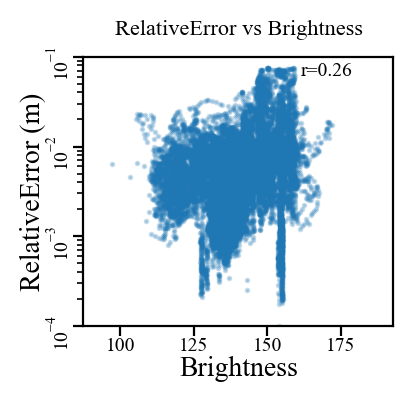

---------------------------------------------------------------------------
Contrast: Pearson correlation: -0.35


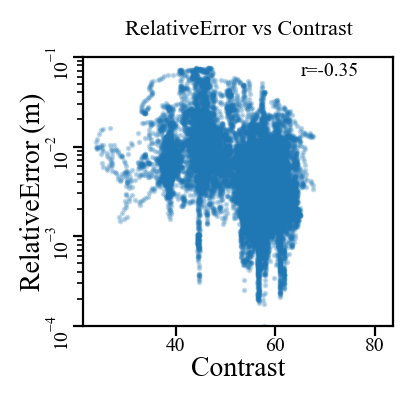

---------------------------------------------------------------------------
Entropy: Pearson correlation: -0.34


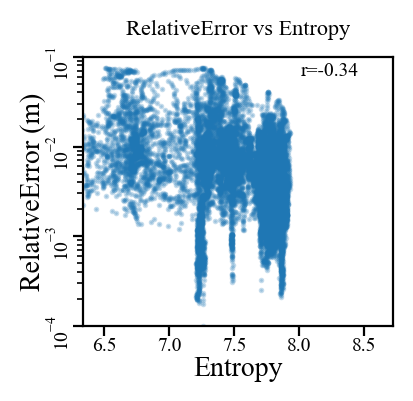

---------------------------------------------------------------------------
Laplacian: Pearson correlation: 0.22


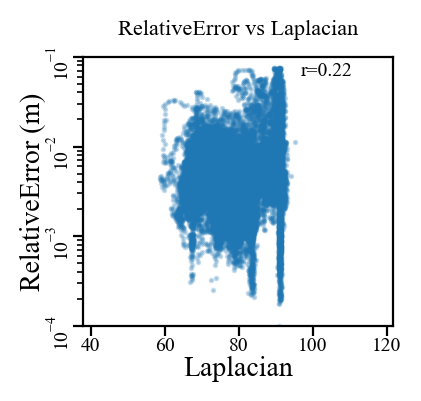

---------------------------------------------------------------------------
AvgMPDepth: Pearson correlation: -0.09


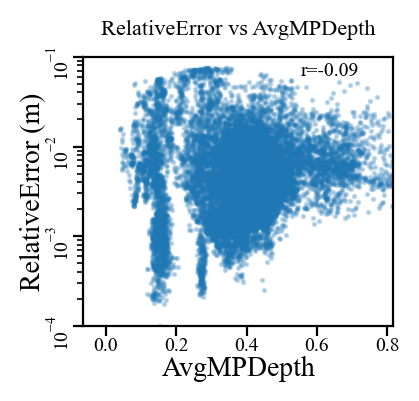

---------------------------------------------------------------------------
VarMPDepth: Pearson correlation: 0.04


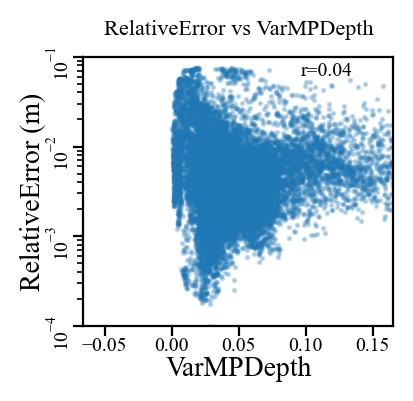

---------------------------------------------------------------------------
PrePOOutlier: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


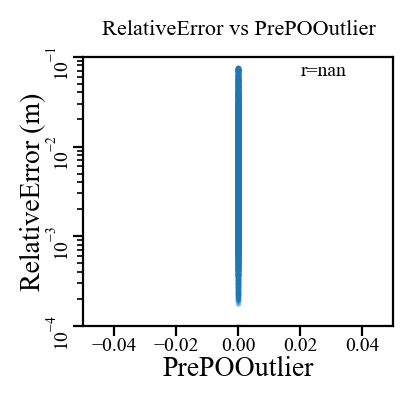

---------------------------------------------------------------------------
PrePOKeyMapLoss: Pearson correlation: -0.28


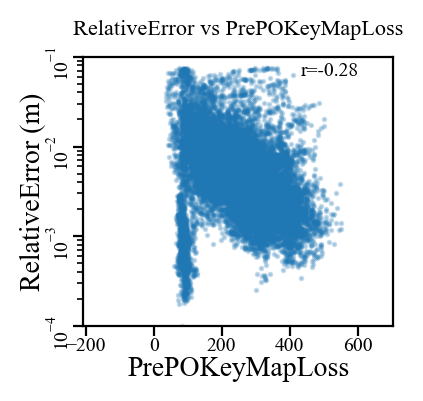

---------------------------------------------------------------------------
Inlier: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


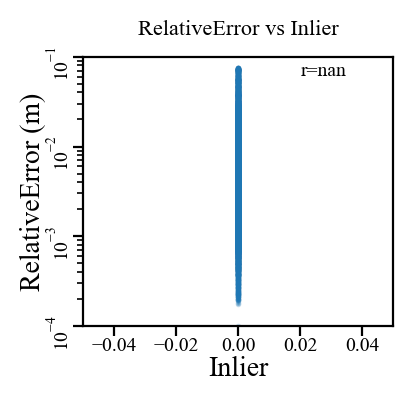

---------------------------------------------------------------------------
PostPOOutlier: Pearson correlation: -0.09


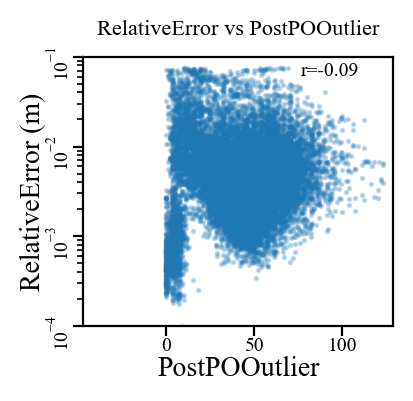

---------------------------------------------------------------------------
PostPOKeyMapLoss: Pearson correlation: -0.28


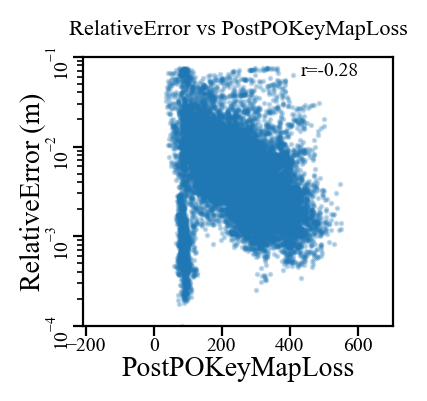

---------------------------------------------------------------------------
MatchedInlier: Pearson correlation: -0.29


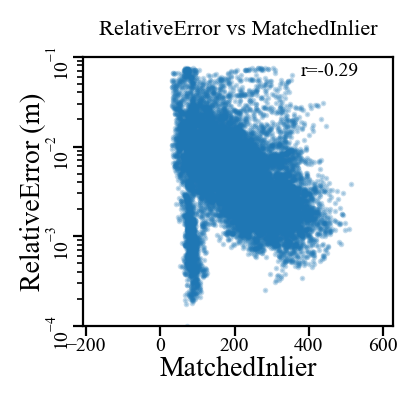

---------------------------------------------------------------------------
NumberKeyPoints: Pearson correlation: -0.13


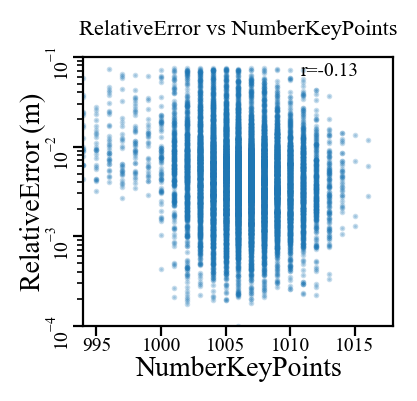

---------------------------------------------------------------------------
DX: Pearson correlation: -0.04


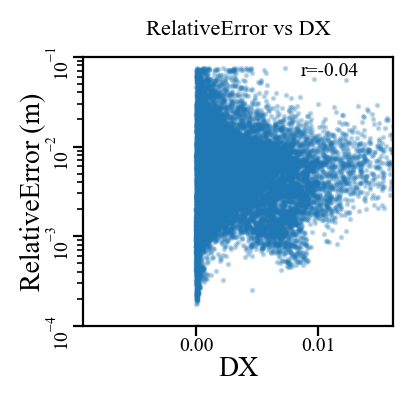

---------------------------------------------------------------------------
DY: Pearson correlation: 0.01


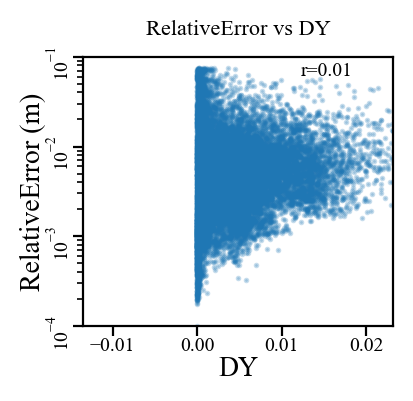

---------------------------------------------------------------------------
DZ: Pearson correlation: 0.07


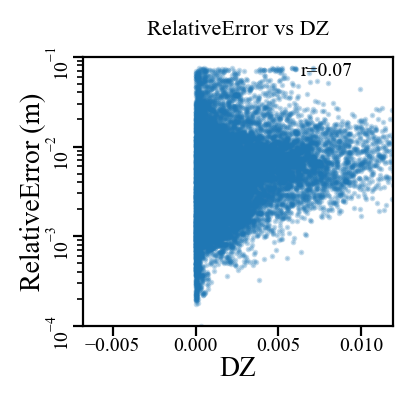

---------------------------------------------------------------------------
Yaw: Pearson correlation: 0.18
Yaw plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
Pitch: Pearson correlation: 0.05
Pitch plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
Roll: Pearson correlation: 0.19
Roll plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
num_LocalKFinQueue: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


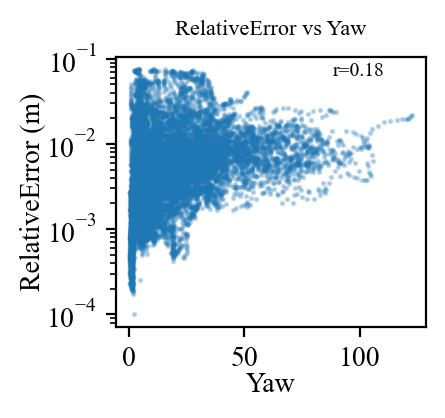

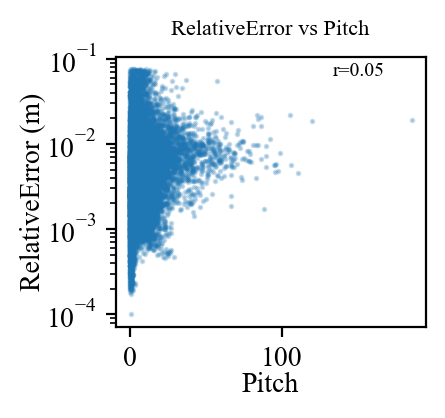

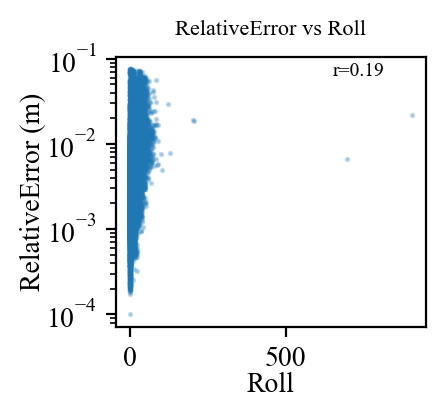

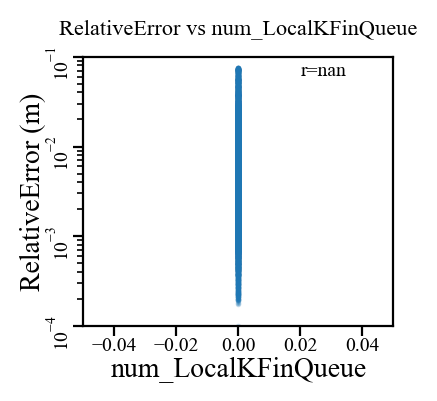

---------------------------------------------------------------------------
num_FixedKF_BA: Pearson correlation: 0.22


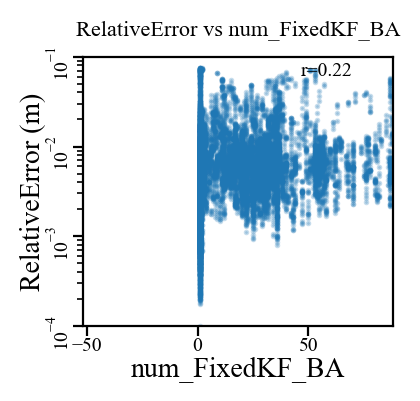

---------------------------------------------------------------------------
num_OptKF_BA: Pearson correlation: -0.20


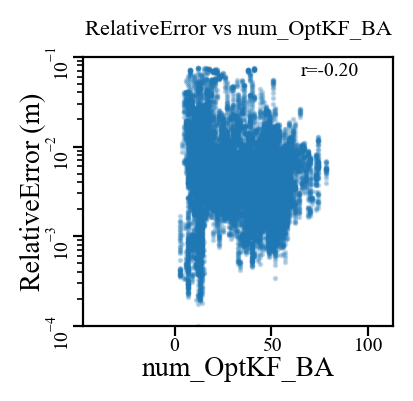

---------------------------------------------------------------------------
num_MPs_BA: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


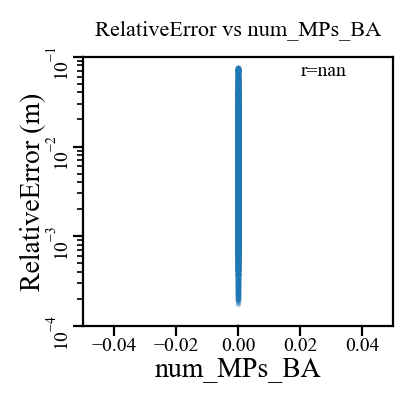

---------------------------------------------------------------------------
num_edges_BA: Pearson correlation: -0.25


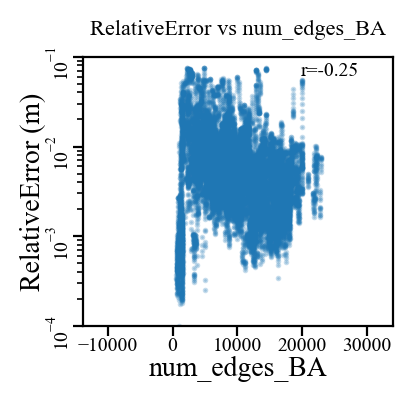

---------------------------------------------------------------------------
num_local_BA: Pearson correlation: 0.41


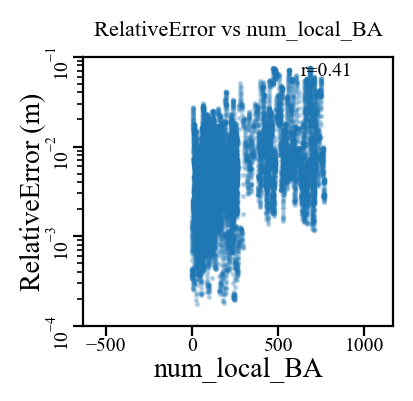

---------------------------------------------------------------------------
local_visual_BA_Err: Pearson correlation: -0.17


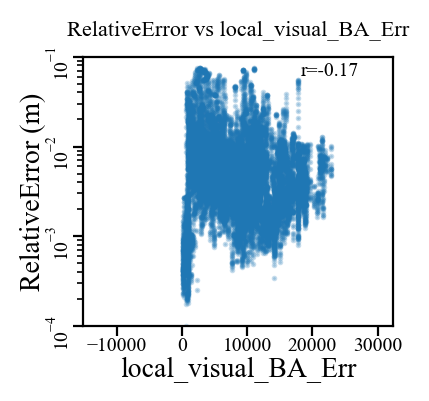

---------------------------------------------------------------------------
num_GlobalKFinQueue: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


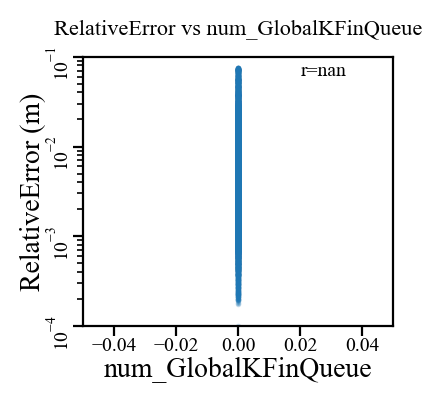

---------------------------------------------------------------------------
num_Global_BA: Pearson correlation: 0.06


/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


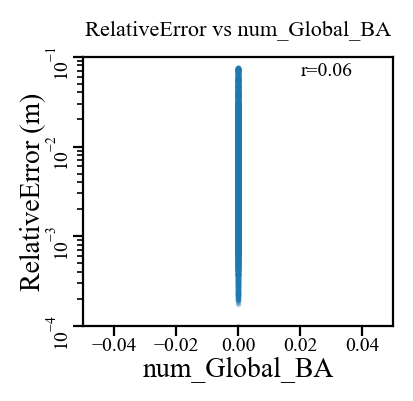

---------------------------------------------------------------------------
global_visual_BA_Err: Pearson correlation: 0.06


/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


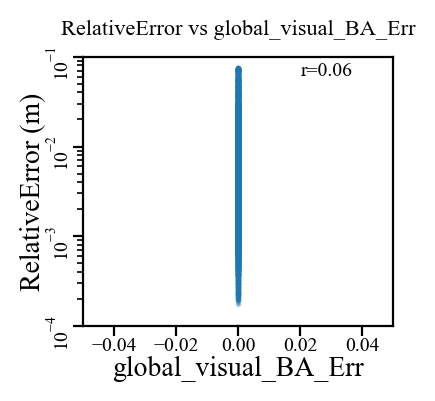

---------------------------------------------------------------------------
CollectionLatency: Pearson correlation: -0.01


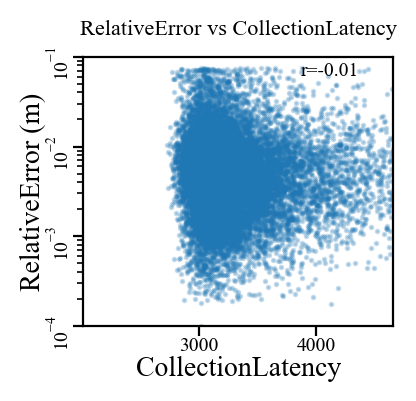

---------------------------------------------------------------------------
RefRatio: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


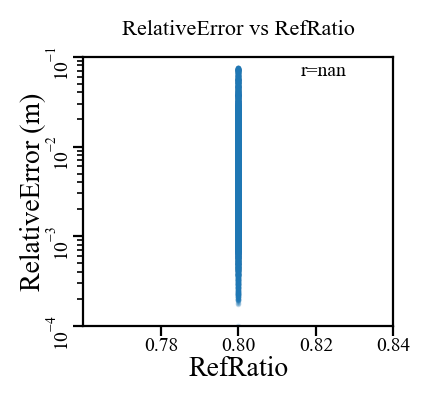

---------------------------------------------------------------------------
MinFrame: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


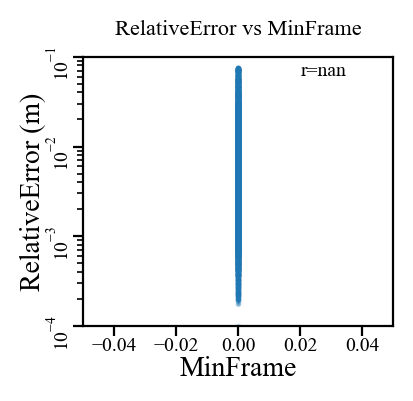

---------------------------------------------------------------------------
MaxFrame: Pearson correlation: nan


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3009096/225439131.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


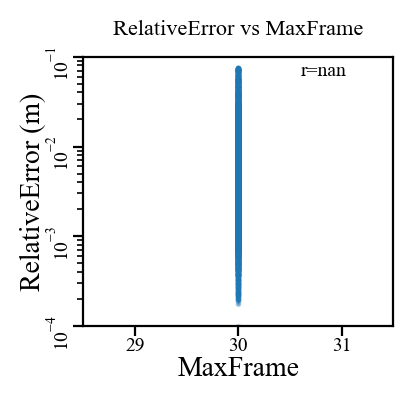

---------------------------------------------------------------------------
dQX: Pearson correlation: -0.02
dQX plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
dQY: Pearson correlation: 0.00
dQY plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
dQZ: Pearson correlation: -0.00
dQZ plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
dQW: Pearson correlation: -0.01
dQW plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
dt: Pearson correlation: 0.06
dt plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------
dQ_mag: Pearson correlation: 0.04
dQ_mag plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------

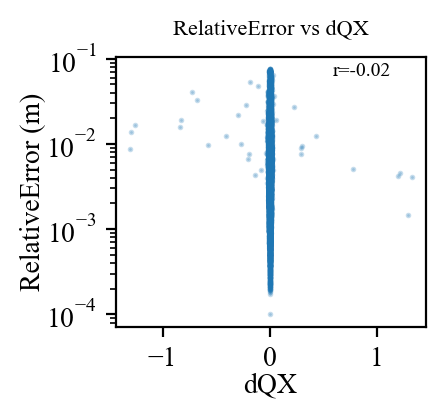

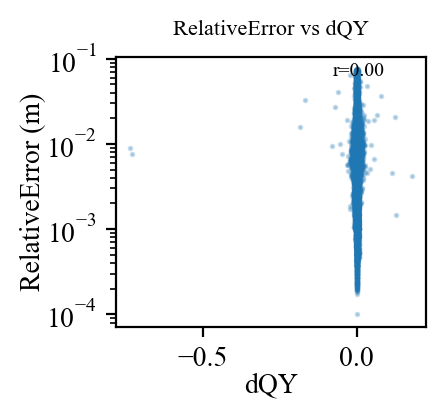

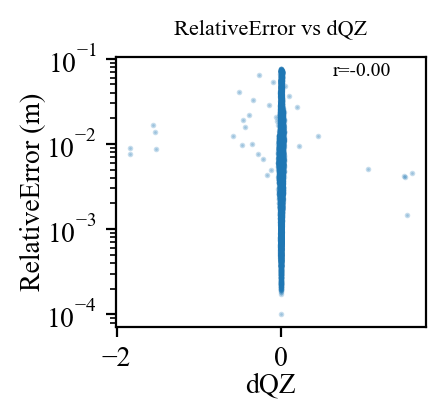

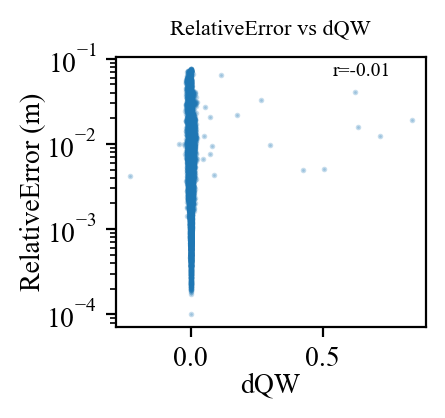

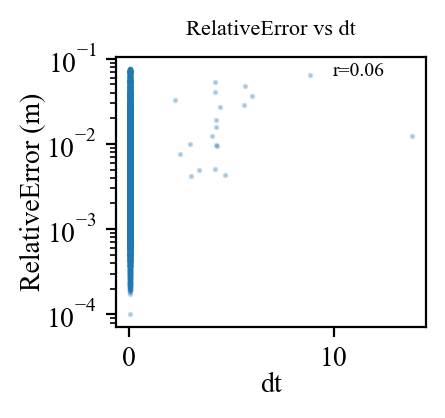

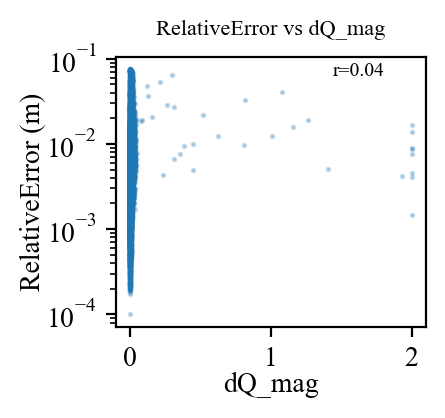

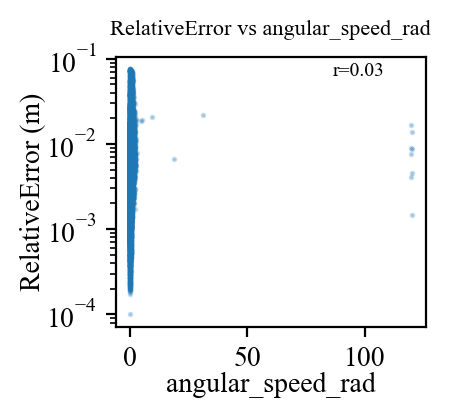

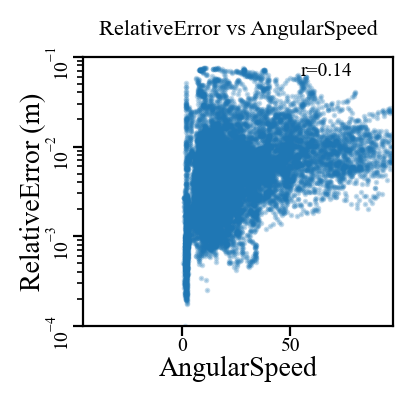

---------------------------------------------------------------------------
Speed: Pearson correlation: 0.02
Speed plot failed. Axis limits cannot be NaN or Inf
---------------------------------------------------------------------------


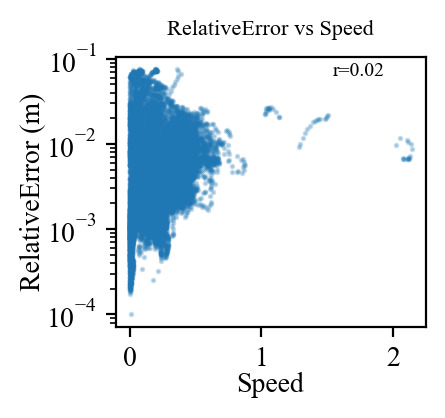

In [53]:
# plot_scatter(concatenated_df, column_x="Speed", xlims=(0,2))
# plot_scatter(concatenated_df, column_x="angular_speed_deg", xlims=(0,20))
# plot_scatter(concatenated_df, column_x="MatchedInlier", xlims=(0,500))
# plot_scatter(concatenated_df, column_x="Laplacian", xlims=(60,95))
for idx, column in enumerate(df.columns[5:]):
    if column in ['PX','PY','PZ','QX','QY','QZ','QW',]:
        continue
    else:
        try:
            plot_scatter(concatenated_df, column_x=column, xlims=None)
        except Exception as e:
            print(f"{column} plot failed. {e}")
        print('-'*75)

Contrast, Entropy, Yaw, angular_speed_deg, MatchedInlier

Contrast: Pearson correlation: -0.35


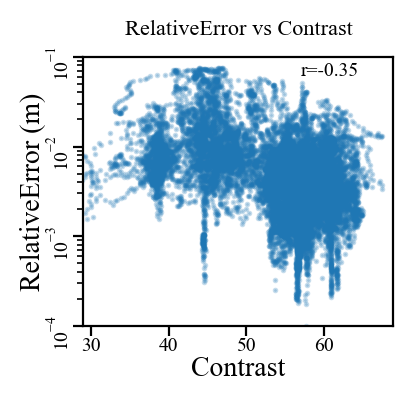

In [74]:
plot_scatter(concatenated_df, column_x="Contrast", xlims=(29,69))

Yaw: Pearson correlation: 0.18


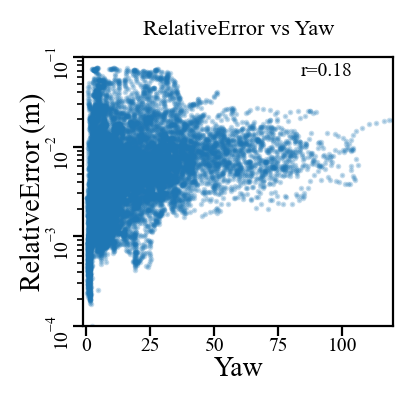

In [55]:
plot_scatter(concatenated_df, column_x="Yaw", xlims=(-1,120))

AngularSpeed: Pearson correlation: 0.14


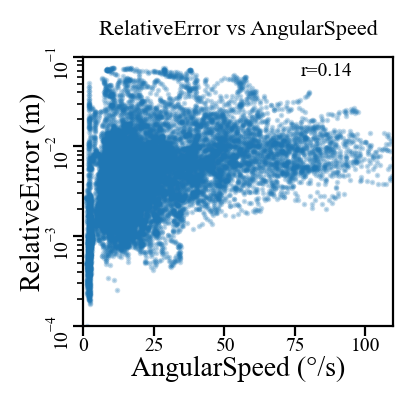

In [56]:
plot_scatter(concatenated_df, column_x="AngularSpeed", xllabel="AngularSpeed (°/s)", xlims=(0,110))

AvgMPDepth: Pearson correlation: -0.09


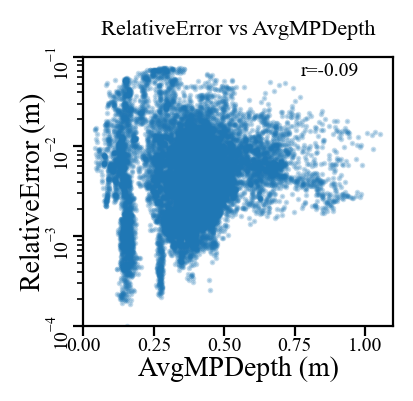

In [57]:
plot_scatter(concatenated_df, column_x="AvgMPDepth", xllabel="AvgMPDepth (m)", xlims=(0,1.1))

MatchedInlier: Pearson correlation: -0.29


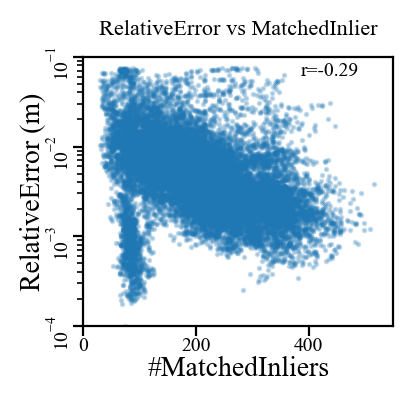

In [58]:
plot_scatter(concatenated_df, column_x="MatchedInlier", xllabel="#MatchedInliers", xlims=(0,550))

NumberKeyPoints: Pearson correlation: -0.13


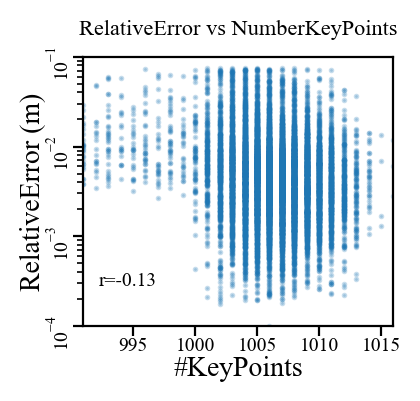

In [73]:
plot_scatter(concatenated_df, column_x="NumberKeyPoints", xlims=(991,1016), xllabel="#KeyPoints", bottomLeft=True)

In [60]:
invalid_index = df[df['RelativeError'].isna()].index
invalid_index

Index([1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591,
       ...
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870],
      dtype='int64', length=165)

In [61]:
init_index = np.min(df[df['TrackMode']==2].index)
remove_indices = pd.Index(range(init_index, init_index+240))
remove_indices

RangeIndex(start=269, stop=509, step=1)

In [62]:
invalid_index = invalid_index.append(remove_indices).drop_duplicates().sort_values()
invalid_index

Index([ 269,  270,  271,  272,  273,  274,  275,  276,  277,  278,
       ...
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870],
      dtype='int64', length=405)